<a href="https://colab.research.google.com/github/chsr00/AI_FOR_CAE2/blob/main/CAE_v1_for_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, UpSampling2D, Input, Convolution2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

import scipy.io
from sklearn.model_selection import train_test_split

print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0


In [2]:
#from google.colab import files
#
#uploaded = files.upload()

## 코드가 돌아가면 파일선택 버튼을 눌러서 upload할 파일 선택
#for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))

In [3]:
#from google.colab import drive
# google drive와 연결 (인증코드 입력해야함)
#drive.mount('/gdrive')

# data_3000 폴더 만듦. zip 파일 압출 풀기
!git clone https://github.com/chsr00/AI_FOR_CAE2.git
! mkdir data_3000
! unzip ./AI_FOR_CAE2/data_3000.zip
! pwd
#! ls -al
#! cd /content/AI_FOR_CAE2
#! ls -al
! mv *.jpg ./data_3000/
#!ls -al ./data_3000


#! mkdir data_3000
#! unzip data_3000.zip -d ./data_3000

Cloning into 'AI_FOR_CAE2'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 45 (delta 17), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (45/45), 4.14 MiB | 7.63 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Archive:  ./AI_FOR_CAE2/data_3000.zip
  inflating: 22.5651.jpg             
  inflating: 23.119.jpg              
  inflating: 23.149.jpg              
  inflating: 23.2255.jpg             
  inflating: 23.2919.jpg             
  inflating: 23.3077.jpg             
  inflating: 23.3701.jpg             
  inflating: 23.388.jpg              
  inflating: 23.4496.jpg             
  inflating: 23.4706.jpg             
  inflating: 23.4709.jpg             
  inflating: 23.4904.jpg             
  inflating: 23.5079.jpg             
  inflating: 23.5414.jpg             
  inflating: 23.5748.jpg             
  inflating: 23.5762.jpg             
  inflating: 23.587.jpg    

0


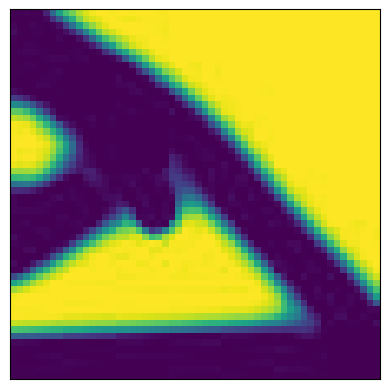

1


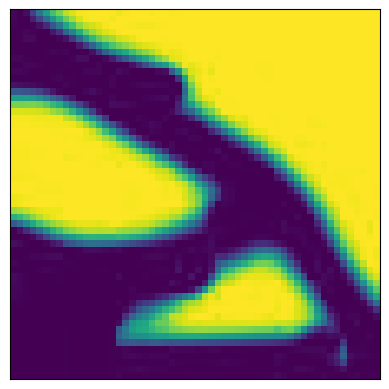

2


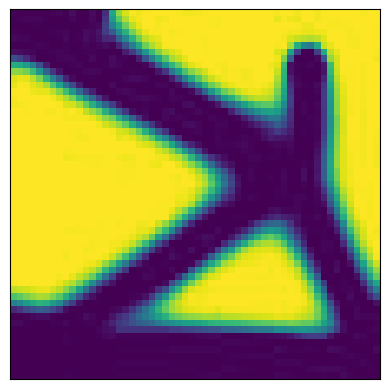

3


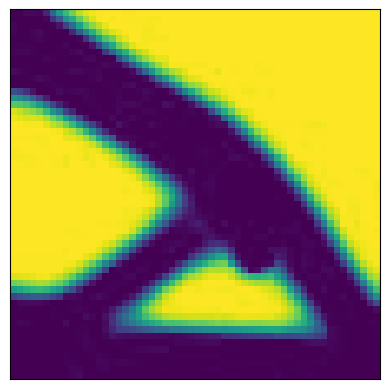

4


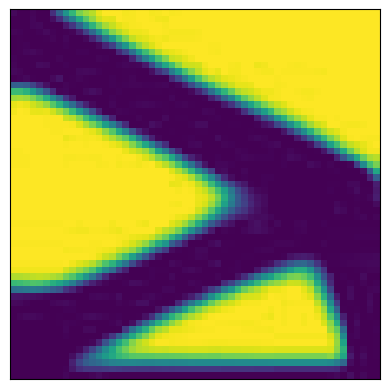

5


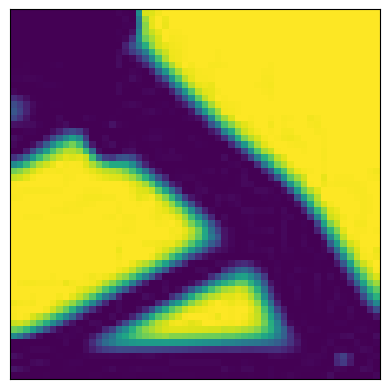

6


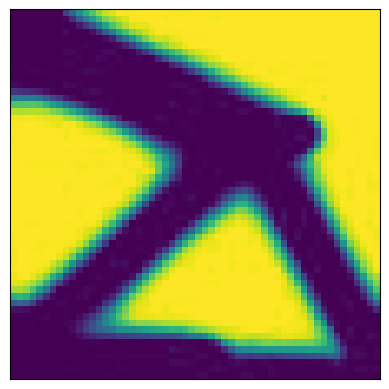

7


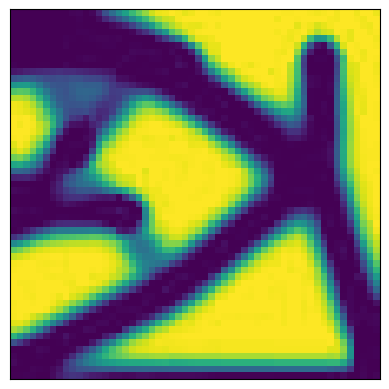

8


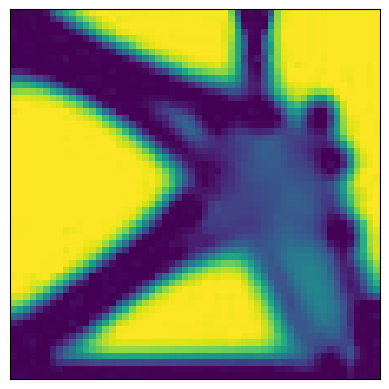

9


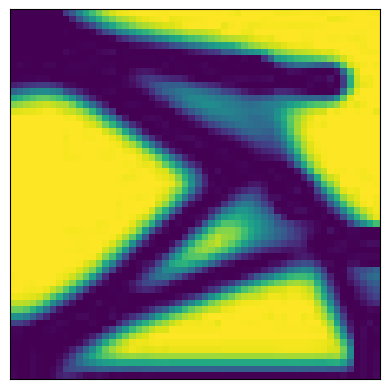

X_shape: (56, 56) Y_shape: ()
X_list shape: (3000, 56, 56) Y_list shape: (3000,)
(2400, 56, 56, 1) (600, 56, 56, 1)


In [4]:
# 압축해제된 데이터 경로 (데이터 있는 파일 경로 입력)
src = './data_3000/'

# 이미지 읽기 및 출력
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    plt.imshow(img)
    plt.xticks([]) # x축 눈금
    plt.yticks([]) # y축 눈금
    plt.show()
    return img

#이미지 읽기
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    return img

#src 경로에 있는 파일 명을 저장
files = os.listdir(src)

X,Y = [],[]
count = 0

# 경로와 파일명을 입력으로 넣어 확인하고
# 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트 추가

for file in files:
  # 데이터의 일부분만 확인해봅니다.
  if count < 10 :
    print(count)
    X.append(img_read_plot(src,file)/255.)
    Y.append(float(file[:-4]))
    count+=1
  else :
    X.append(img_read(src,file)/255.)
    Y.append(float(file[:-4]))

# 전체 X, Y data shape 출력
print('X_shape:',np.shape(X[0]),'Y_shape:',np.shape(Y[0]))
print('X_list shape:',np.shape(X),'Y_list shape:',np.shape(Y))

# hyper parameter 설정
img_size = 56       # 이미지 사이즈
latent_dim = 32     # latent dimension 크기 설정
BUFFER_SIZE = 5600  # 총 이미지 갯수
BATCH_SIZE = 20     # 배치 사이즈(나눴을때 이미지 갯수에 딱 떨어지게 설정해야 함)

# Train set(80%), Test set(20%)으로 나누기
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=1,shuffle=True)

# CNN layer에 들어갈 수 있게 (x, 56, 56, 1) 차원으로 맞춰줌
X_train = np.reshape(X_train, (len(X_train), img_size, img_size, 1))
X_test = np.reshape(X_test, (len(X_test), img_size, img_size, 1))
print(np.shape(X_train),np.shape(X_test))

In [5]:
# 인코더
def encoder():

  model = tf.keras.Sequential()
  model.add(Conv2D(5, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 1)))
  model.add(MaxPooling2D((2, 2), padding='same'))
  model.add(Conv2D(10, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2), padding='same'))
  model.add(Conv2D(15, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2), padding='same'))
  model.add(Conv2D(20, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2), padding='same'))
  model.add(Conv2D(25, (3, 3), activation='relu', padding='same'))
  model.add(Flatten())
  # latent dimension으로 축소됨
  model.add(Dense(latent_dim))

  return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 5)         50        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 5)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 10)        460       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 10)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 15)        1365      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 15)         0

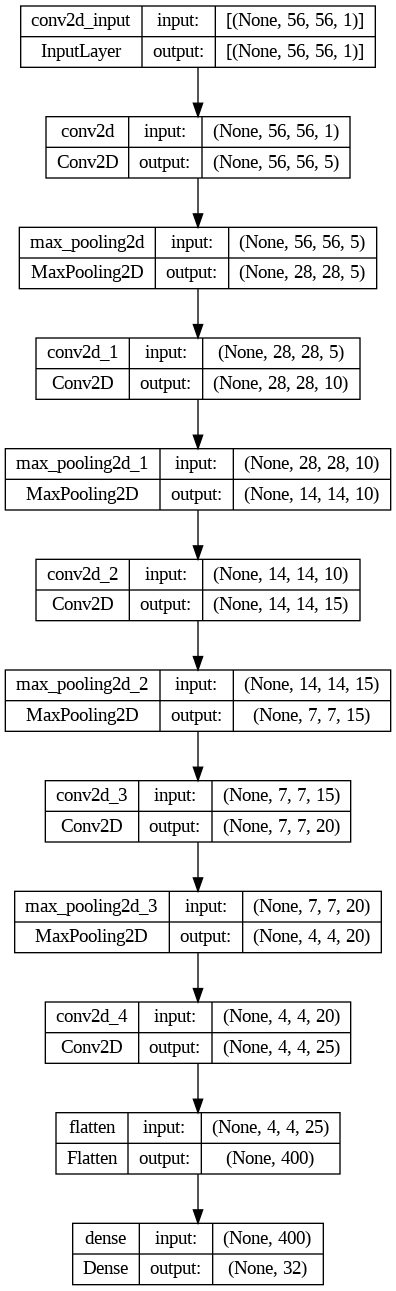

In [6]:
# 인코더 함수를 실행해서 모델을 build 후 변수에 집어넣고, 모델 구조를 살펴봄
e_model = encoder()
e_model.summary()
plot_model(e_model, show_shapes=True)

In [7]:
# 디코더
def decoder():

  model = tf.keras.Sequential()
  model.add(Dense(7 * 7 * 56, input_shape=(latent_dim,)))
  model.add(Reshape((7, 7, 56)))
  model.add(Conv2D(56, (2, 2), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(56, (2, 2), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(56, (2, 2), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Dropout(0.5))
  model.add(Conv2D(1, (2, 2), padding='same'))

  return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2744)              90552     
                                                                 
 reshape (Reshape)           (None, 7, 7, 56)          0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 56)          12600     
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 56)       0         
 )                                                               
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 56)        12600     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 56)       0         
 2D)                                                  

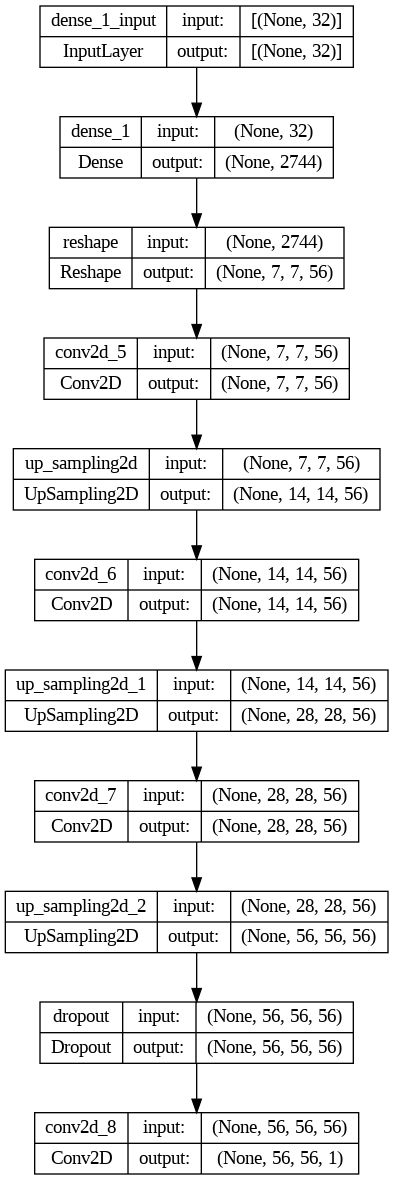

In [8]:
# 디코더 함수를 실행해서 모델을 build 후 변수에 집어넣고, 모델 구조를 살펴봄
d_model = decoder()
d_model.summary()
plot_model(d_model, show_shapes=True)

In [9]:
# 모델을 합쳐줌
input_img = Input(shape=(img_size, img_size, 1))
model = Model(input_img, d_model(e_model(input_img)), name='autoencoder')

# optimizer 설정과 model complie하면서 optimizer와 loss 함수, loss 평가지표로 mae 설정
adam=Adam(lr=0.00008, beta_1=0.9)
model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mae'])

In [10]:
# model.fit을 써서 학습. 학습과정을 history에 저장
history = model.fit(X_train, X_train,
                    batch_size=20,
                    epochs=100,
                    verbose=2,
                    validation_data=(X_test, X_test),
                    shuffle=True)

Epoch 1/100
120/120 - 37s - loss: 0.1240 - mae: 0.2722 - val_loss: 0.0591 - val_mae: 0.1774 - 37s/epoch - 311ms/step
Epoch 2/100
120/120 - 27s - loss: 0.0497 - mae: 0.1601 - val_loss: 0.0333 - val_mae: 0.1203 - 27s/epoch - 225ms/step
Epoch 3/100
120/120 - 27s - loss: 0.0341 - mae: 0.1293 - val_loss: 0.0262 - val_mae: 0.1049 - 27s/epoch - 222ms/step
Epoch 4/100
120/120 - 34s - loss: 0.0278 - mae: 0.1163 - val_loss: 0.0227 - val_mae: 0.0982 - 34s/epoch - 280ms/step
Epoch 5/100
120/120 - 27s - loss: 0.0241 - mae: 0.1083 - val_loss: 0.0200 - val_mae: 0.0882 - 27s/epoch - 225ms/step
Epoch 6/100
120/120 - 27s - loss: 0.0218 - mae: 0.1033 - val_loss: 0.0178 - val_mae: 0.0840 - 27s/epoch - 226ms/step
Epoch 7/100
120/120 - 27s - loss: 0.0199 - mae: 0.0988 - val_loss: 0.0166 - val_mae: 0.0783 - 27s/epoch - 224ms/step
Epoch 8/100
120/120 - 27s - loss: 0.0187 - mae: 0.0960 - val_loss: 0.0157 - val_mae: 0.0778 - 27s/epoch - 229ms/step
Epoch 9/100
120/120 - 27s - loss: 0.0175 - mae: 0.0930 - val_los

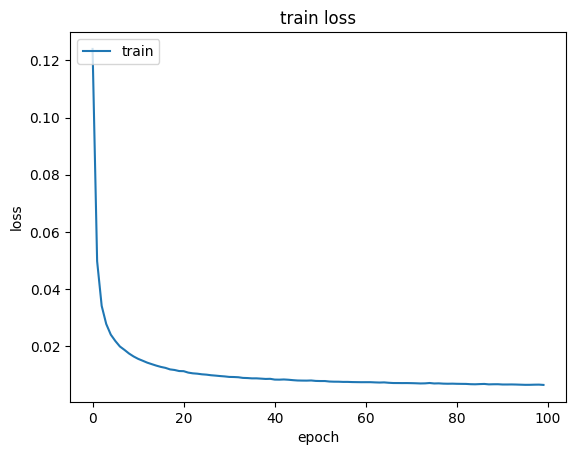

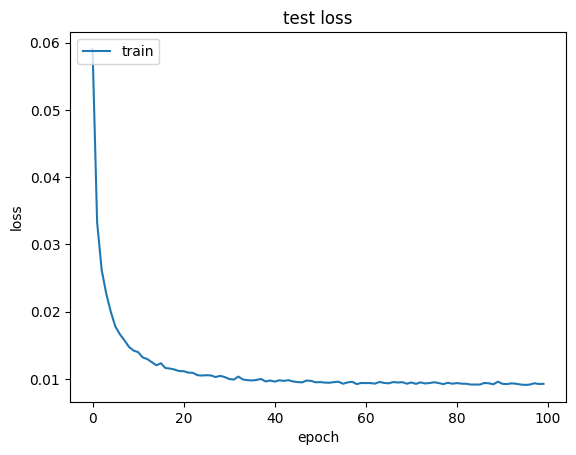

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for mean_absolute_error
plt.plot(history.history['val_loss'])
plt.title('test loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

19/19 [==============================] - 1s 59ms/step


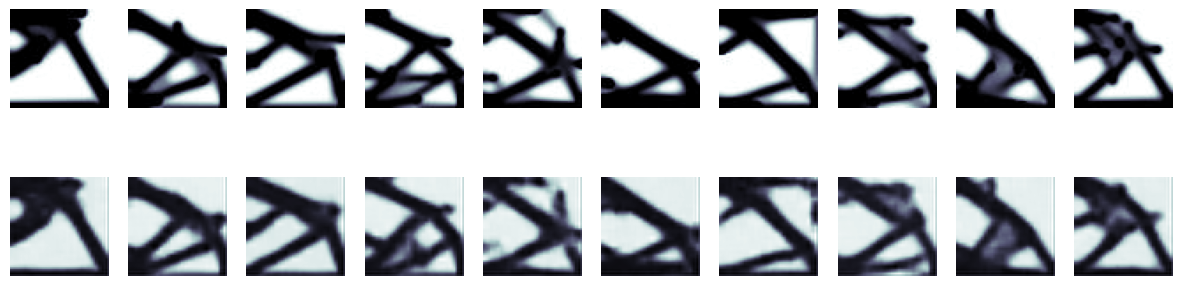

In [12]:
sample_size = 10                        # 보여줄 sample 갯수 설정
prediction = model.predict(X_test)      # test 데이터로 이미지 복원(predict 함수 사용)

# plot 하기
fig, ax = plt.subplots(2, sample_size, figsize=(15, 4))
for i in range(sample_size):
  org_img = X_test[i].reshape(56,56)
  rec_img = prediction[i].reshape(56,56)

  ax[0][i].set_axis_off()
  ax[1][i].set_axis_off()

  ax[0][i].imshow(org_img, cmap=plt.cm.bone)
  ax[1][i].imshow(rec_img, cmap=plt.cm.bone)

plt.show()